In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D,MaxPooling2D, Flatten, Conv2D, BatchNormalization, Lambda, Reshape
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/"My Drive"/FMA_Music

/content/drive/My Drive/FMA_Music


### Load training and Validation arrays

In [4]:


dict_genres = {'Electronic':0,  'Folk':1,  'Pop' :2, 'Instrumental':3 }

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Folk', 2: 'Pop', 3: 'Instrumental'}


In [5]:
npzfile = np.load('loaddata/suf_train_arr.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)


['arr_0', 'arr_1']
(9597, 420, 128) (9597,)


In [6]:
npzfile = np.load('loaddata/suf_valid_arr.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)


['arr_0', 'arr_1']
(1200, 420, 128) (1200,)


In [0]:
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)

### CNN - RNN Model

In [0]:
batch_size = 32
num_classes = 4
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [0]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model
    

In [0]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, x_train.shape[1])
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    

    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [earlyStopping,checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [0]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

W0624 09:08:11.997462 140667962320768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 09:08:12.035840 140667962320768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 09:08:12.059522 140667962320768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 09:08:12.131577 140667962320768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0624 09:08:12.155078 

Building model...


W0624 09:08:12.829715 140667962320768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0624 09:08:12.840286 140667962320768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0624 09:08:13.020995 140667962320768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 56)          224       
_________________________________________________________________
activation_1 (Activation)    (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 56)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None, 56)          15736     
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


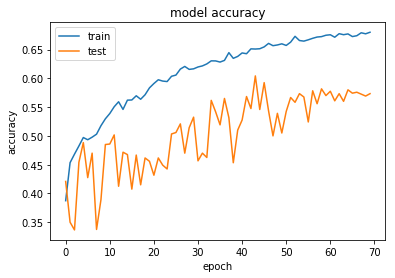

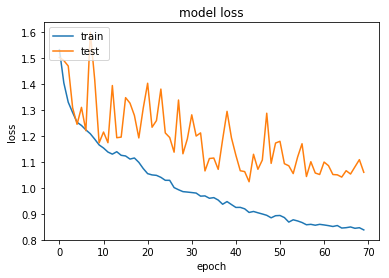

In [14]:
show_summary_stats(history)

In [15]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(1200,) (1200,)
              precision    recall  f1-score   support

  Electronic       0.62      0.68      0.65       300
        Folk       0.68      0.69      0.69       300
         Pop       0.42      0.53      0.47       300
Instrumental       0.62      0.40      0.49       300

    accuracy                           0.57      1200
   macro avg       0.59      0.57      0.57      1200
weighted avg       0.59      0.57      0.57      1200



In [16]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.5733333333333334


### Connect to Test Set

In [0]:
from keras.models import load_model

weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)

In [18]:
npzfile = np.load('loaddata/test_arr30.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(1200, 420, 128) (1200,)


In [19]:
#X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1200,) (1200,)
              precision    recall  f1-score   support

  Electronic       0.66      0.66      0.66       300
        Folk       0.30      0.27      0.28       300
         Pop       0.40      0.44      0.42       300
Instrumental       0.40      0.39      0.39       300

    accuracy                           0.44      1200
   macro avg       0.44      0.44      0.44      1200
weighted avg       0.44      0.44      0.44      1200



In [20]:
y_test = keras.utils.to_categorical(y_test, num_classes=4)
model.evaluate(X_test, y_test)

1200/1200 [==============================] - 1s 1ms/step


[1.334909590880076, 0.44]

In [21]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[197  25  57  21]
 [  0  81  98 121]
 [ 87  43 132  38]
 [ 14 122  46 118]]


In [22]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.44


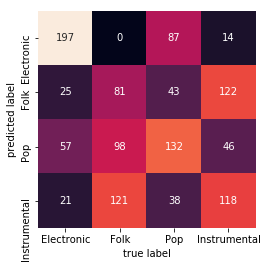

In [23]:
### 4 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
